<a href="https://colab.research.google.com/github/DeepCodeSec/ml1000-p1/blob/working_models/Project1_wine_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working code for wine classification problem.

**Dataset:**
* wine quality data retrieved from https://archive.ics.uci.edu/ml/datasets/Wine+Quality

* using the white wine csv only (had more observations than the red)


**Problem:**
* how do we test if the wine is high quality and should be priced accordingly?

## Install packages and load in dataset

* When using colab, need to install pycaret everytime
* read in the wine quality dataset using the "raw" link from the git repository
  * alternatively can use any other url for the data that ends in .csv
  * trying to avoid linking the colab notebook to git, google drive or local server for reproducibility

In [42]:
!pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pycaret-2.3.10-py3-none-any.whl (320 kB)
  Using cached spacy-2.3.9-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.0 MB)
  Using cached scikit_plot-0.3.7-py3-none-any.whl (33 kB)
  Using cached imbalanced_learn-0.7.0-py3-none-any.whl (167 kB)
  Using cached lightgbm-3.3.5-py3-none-manylinux1_x86_64.whl (2.0 MB)
  Using cached mlxtend-0.21.0-py2.py3-none-any.whl (1.3 MB)
  Using cached pyLDAvis-3.3.1.tar.gz (1.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached scikit_learn-0.23.2-cp38-cp38-manylinux1_x86_64.whl (6.8 MB)
  Using cached numba-0.54.1-cp38-cp38-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (3.3 MB)
  Using cached kmodes-0.12.2-py2.py3-none-any.whl (20 kB)
  Using cached Boruta-0.3-py3-none-any.whl (56 k

In [17]:
import pandas as pd

df_path = 'https://raw.githubusercontent.com/DeepCodeSec/ml1000-p1/working_models/data/winequality-white.csv'  
dataset = pd.read_csv(df_path, 
                   sep=';') #the separater in the raw data is ;. need to indicate so columns are found
dataset.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [18]:
# What is the distribution of the target variable (quality)
dataset.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


### Recode quality to a binary label
**Original**: quality of wine rated from 0-10 with 10 as the best

Above shows that the minimum rating was a 3 and max is 9. The mean and median are both ~6.

According to this website, a rating of 7+ is good wine. It isn't a big deal if the classes are imbalanced, that just dictates which performance metric we use. It is more important to create our classes based on real-world knowledge.  https://vineroutes.com/wine-rating-system/#:~:text=Wines%20rated%2089%20and%20above,outstanding%20for%20its%20particular%20type.

**New**: binary label (target variable) of 'standard' or 'high quality' where a rating of 7 or above  is high quality and 6 or below is standard

In [19]:
import numpy as np

#add binary classification label
dataset['new_quality'] = np.where(dataset['quality'] > 6, 
                               'high_quality',
                               'standard')
dataset.head(100)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,new_quality
0,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,standard
1,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,standard
2,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,standard
3,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,standard
4,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,7.1,0.260,0.29,12.4,0.044,62.0,240.0,0.9969,3.04,0.42,9.2,6,standard
96,6.0,0.340,0.66,15.9,0.046,26.0,164.0,0.9979,3.14,0.50,8.8,6,standard
97,8.6,0.265,0.36,1.2,0.034,15.0,80.0,0.9913,2.95,0.36,11.4,7,high_quality
98,9.8,0.360,0.46,10.5,0.038,4.0,83.0,0.9956,2.89,0.30,10.1,4,standard


In [20]:
#drop old quality column and rename new
dataset = dataset.drop(columns=['quality']) #drops old column
dataset = dataset.rename(columns={'new_quality':'quality'}) #renames back to quality

dataset.head() #double check it did what we asked

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,standard
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,standard
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,standard
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,standard
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,standard


## Exploratory analysis report

The code below automatically creates an exploratory data analysis report. The report is output as an html file in the local files (see the files pane on the left.

For the final report/project we will want to highlight specific aspects from the EDA document that justify our decisions below and code these explicitly. For example if we use a parametric classifier that needs independent (non-correlated) predictors, we would want to show the correlation matrix in the notebook that gets published and comment on how much/little the predictors are correlated and how we are dealing with them.

In [21]:
#Load libraries for exploratory analysis
!pip3 install pandas_profiling --upgrade
import pandas_profiling
from pandas_profiling import ProfileReport
import pandas as pd

pr = ProfileReport(dataset)

pr.to_file(output_file="EDA.html")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset has:
* 12 variables (11 numeric predictors and 1 categorical target/label)
* 4898 observations
* no missing values

Distributions:
* imbalanced label classes (~20% high quality and 80% standard)
  * again, this is not an issue, it just tells us that we need to think about undersampling and choose the appropriate performance metric
* most of the predictor variables are fairly normally distributed
* alcohol, volatile acidity, and residual sugar are not normally distributed, so we can consider transforming these columns (eg log transformation) if needed


Interactions:
* skipping, not super interesting for classification because pycaret is just going to run a dozen models anyway. We are more interested in the interactions for a regression type problem where, for example, the revenue from tv x radio adcertisements is predicted better than from tv ads or radio adds alone

Correlations:
* moderate correlation between density + residual sugar, density + alcohol, alcohol + chlorides
* for now leaving, but revisit for fine tuning if we are getting poor performance

Duplicate rows:
* therer are a number of duplicate rows. It is hard to say if these are genuinely duplicates and should be removed, or if they are coincidental duplicates (ie 2 wine samples happen to have the same measurements)


## Split dataset

* 5% test set (unseen until after model is finalized) 
* The remaining 95% will be split in the pycaret setup function

First we remove the 5% test set before any feature engineering to avoid data leakage. Test set is randomly shuffled.

After feature engineering, the remaining data will be split into training and validation sets that follow the same distribution of target labels (ie using stratified sampling).

We also need to take into consideration the sampling method because we have imbalanced classes
* under/over sample
* stratified sampling 
* etc

In [22]:
# split data into 95% and 5%
data = dataset.sample(frac=0.95, random_state=786)
data_unseen = dataset.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (4653, 12)
Unseen Data For Predictions: (245, 12)


In [23]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.9,0.28,0.49,7.7,0.045,48.0,195.0,0.99540,3.04,0.55,11.0,standard
1,5.0,0.24,0.19,5.0,0.043,17.0,101.0,0.99438,3.67,0.57,10.0,standard
2,8.3,0.26,0.31,2.0,0.029,14.0,141.0,0.99077,2.95,0.77,12.2,standard
3,7.7,0.25,0.30,7.8,0.038,67.0,196.0,0.99555,3.10,0.50,10.1,standard
4,4.4,0.32,0.39,4.3,0.030,31.0,127.0,0.98904,3.46,0.36,12.8,high_quality


In [24]:
data_unseen.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,standard
1,8.6,0.23,0.40,4.2,0.035,17.0,109.0,0.9947,3.14,0.53,9.7,standard
2,6.6,0.16,0.40,1.5,0.044,48.0,143.0,0.9912,3.54,0.52,12.4,high_quality
3,7.4,0.34,0.42,1.1,0.033,17.0,171.0,0.9917,3.12,0.53,11.3,standard
4,6.0,0.19,0.26,12.4,0.048,50.0,147.0,0.9972,3.30,0.36,8.9,standard


## Data cleaning decisions

* Do outlier/anomaly analysis here. Since the dataset has lower number of observations, opt for solutions that retain as much data as possible (eg capping the data as opposed to removing rows)
* make decisions about transformations etc here

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4653 non-null   float64
 1   volatile acidity      4653 non-null   float64
 2   citric acid           4653 non-null   float64
 3   residual sugar        4653 non-null   float64
 4   chlorides             4653 non-null   float64
 5   free sulfur dioxide   4653 non-null   float64
 6   total sulfur dioxide  4653 non-null   float64
 7   density               4653 non-null   float64
 8   pH                    4653 non-null   float64
 9   sulphates             4653 non-null   float64
 10  alcohol               4653 non-null   float64
 11  quality               4653 non-null   object 
dtypes: float64(11), object(1)
memory usage: 436.3+ KB


* No categorical variables other than the target (class) variable, so no categorical encoding necessary
* Recall from EDA that alcohol, volatile acidity, and residual sugar were not normally distributed, so we can consider transforming these columns (eg log transformation) if needed. For now I will leave and see how the modle does.
* We already know that the data does not contain missing values (from the source and from EDA), so no imutation or row removal necessary.
* We could do feature selection, but since we only have 11 predictors, it is safe to start with a brute force model (ie we just use everything and see what happens)
* Should check for outliers and decide what to do with them. See below:

### Outlier analysis

Two options: 
* 1) When lots of observations in dataset and only a few rows with outlier values (for any column), just remove rows containing outliers.
* 2) When fewer observations and more rows containing outlier values, cap the values at the IQR (interquartile range)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


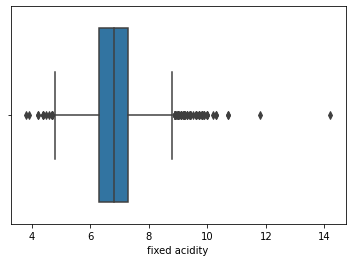

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


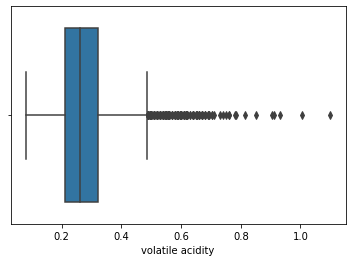

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


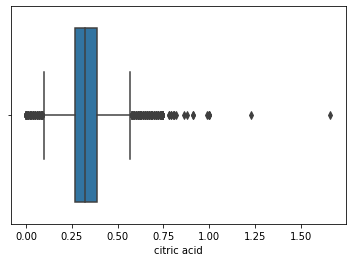

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


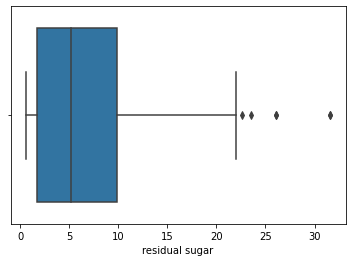

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


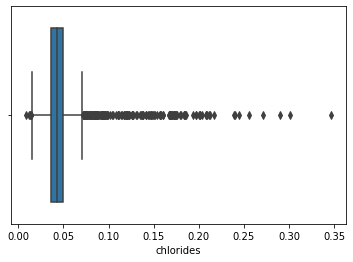

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


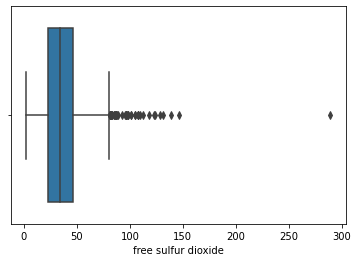

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


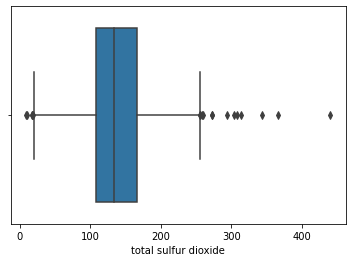

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


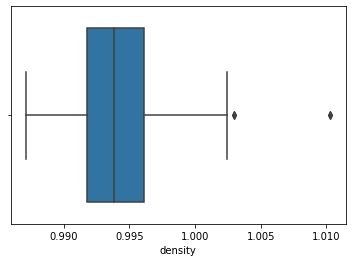

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


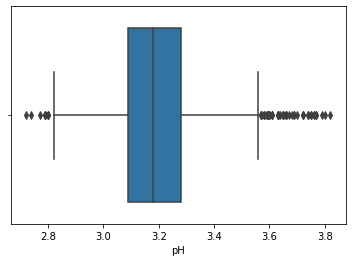

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


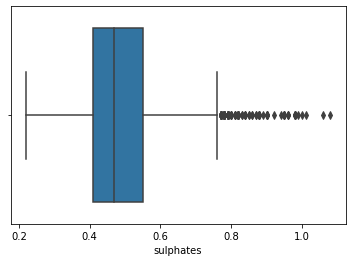

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


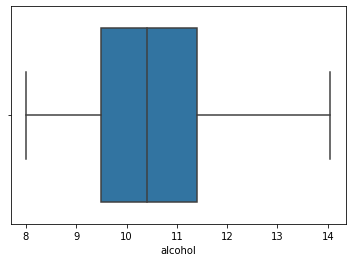

In [36]:
# Outlier analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

cols = list(data.columns)

#Create boxplot for every numeric feature (cols 0-11) to show outliers
for col in cols[0:-1]:
  plt.figure()
  sns.boxplot(data[col])
  plt.show()


The boxplots indicate that most of the predictors contain outlier values. Some of these predictors, like chlorides, contain a lot of outliers. Therefore, if we manipulate these values, we'll want to cap them. Sometimes outliers are meaningful to our investigation, so it doesn't make sense to remove or cap. https://www.theanalysisfactor.com/outliers-to-drop-or-not-to-drop/

For now, I'm doing nothing. We can discuss as a group.

## Training classifier models

Now the main event, training classifiers.

In [43]:
from pycaret.classification import *

In [44]:
#setup experiment
exp_P1clf = setup(data = data, target = 'quality', data_split_stratify = True, 
                  session_id = 123)


,Description,Value
0,session_id,123
1,Target,quality
2,Target Type,Binary
3,Label Encoded,"high_quality: 0, standard: 1"
4,Original Data,"(4653, 12)"
5,Missing Values,False
6,Numeric Features,11
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='quality',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_stra...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluste

https://pycaret.readthedocs.io/en/stable/api/classification.html

* default train split is 0.7 training 0.3 validation
* data_split_stratify = True means that the training and validation sets have the same proportion of each class (ie high_quality vs standard wines) 

Options:

* could set transformation to true to make data more gaussian (normal distribution)
* can remove multicolinarity (deals with correlated predictors)
* can also set to do automatic feature selection


In [45]:
#Find best model
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8747,0.9111,0.9609,0.8889,0.9234,0.5829,0.5977,0.662
rf,Random Forest Classifier,0.8677,0.9001,0.9554,0.8856,0.9190,0.5598,0.5733,0.875
lightgbm,Light Gradient Boosting Machine,0.8557,0.8818,0.9370,0.8862,0.9108,0.5345,0.5413,0.358
gbc,Gradient Boosting Classifier,0.8222,0.8518,0.9370,0.8516,0.8922,0.3914,0.4071,0.470
lr,Logistic Regression,0.8017,0.7736,0.9570,0.8203,0.8833,0.2472,0.2889,0.742
dt,Decision Tree Classifier,0.8017,0.7143,0.8678,0.8783,0.8729,0.4212,0.4220,0.038
ridge,Ridge Classifier,0.7995,0.0000,0.9738,0.8095,0.8840,0.1880,0.2505,0.030
ada,Ada Boost Classifier,0.7980,0.8264,0.9112,0.8439,0.8762,0.3313,0.3391,0.188
lda,Linear Discriminant Analysis,0.7952,0.7786,0.9354,0.8265,0.8775,0.2663,0.2892,0.021
dummy,Dummy Classifier,0.7848,0.5000,1.0000,0.7848,0.8794,0.0000,0.0000,0.023


INFO:logs:create_model_container: 14
INFO:logs:master_model_container: 14
INFO:logs:display_container: 2
INFO:logs:ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


The top 3 classifiers, extra trees, random forest, and light gradient boosting all have similar accuracy, auc and F1 scores. Let's tune all three and see which of the tuned models performs best.

**Note:**
Since we have imbalanced classes, accuracy is not our most important performance metric. Let's talk about it as a group, but for now I'll tune for F1

In [46]:
# train a extra tree model
et = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8405,0.8877,0.9451,0.8638,0.9026,0.4668,0.4816
1,0.8650,0.9142,0.9648,0.8759,0.9182,0.5374,0.5586
2,0.9049,0.9479,0.9727,0.9121,0.9414,0.6907,0.7009
3,0.8865,0.9124,0.9648,0.8982,0.9303,0.6266,0.6385
4,0.8804,0.9251,0.9375,0.9125,0.9249,0.6319,0.6333
5,0.8650,0.8920,0.9727,0.8706,0.9188,0.5260,0.5558
6,0.8957,0.9248,0.9727,0.9022,0.9361,0.6549,0.6688
7,0.8923,0.9258,0.9647,0.9044,0.9336,0.6506,0.6602
8,0.8369,0.8682,0.9412,0.8633,0.9006,0.4522,0.4656


INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 3
INFO:logs:ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)
INFO:logs:create_model() succesfully completed......................................


In [47]:
# train a random forest model
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8252,0.8681,0.9451,0.8486,0.8942,0.3981,0.4182
1,0.8650,0.9193,0.9648,0.8759,0.9182,0.5374,0.5586
2,0.9080,0.9389,0.9688,0.9185,0.9430,0.7057,0.7125
3,0.8712,0.9134,0.9375,0.9023,0.9195,0.5971,0.5998
4,0.8773,0.9206,0.9414,0.9060,0.9234,0.6162,0.6191
5,0.8558,0.8677,0.9531,0.8746,0.9121,0.5145,0.5297
6,0.8926,0.9124,0.9766,0.8961,0.9346,0.6385,0.6573
7,0.8862,0.9223,0.9569,0.9037,0.9295,0.6348,0.6419
8,0.8215,0.8430,0.9373,0.8505,0.8918,0.3898,0.4052


INFO:logs:create_model_container: 16
INFO:logs:master_model_container: 16
INFO:logs:display_container: 4
INFO:logs:RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)
INFO:logs:create_model() succesfully completed......................................


In [48]:
# train a lgb model
lgb = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8405,0.8430,0.9412,0.8664,0.9023,0.4729,0.4851
1,0.8405,0.9046,0.9297,0.8750,0.9015,0.4842,0.4904
2,0.8804,0.9183,0.9375,0.9125,0.9249,0.6319,0.6333
3,0.8896,0.9015,0.9375,0.9231,0.9302,0.6656,0.6661
4,0.8712,0.9084,0.9336,0.9053,0.9192,0.6014,0.6032
5,0.8282,0.8523,0.9297,0.8623,0.8947,0.4316,0.4408
6,0.8834,0.9125,0.9648,0.8949,0.9286,0.6143,0.6274
7,0.8585,0.8980,0.9255,0.8973,0.9112,0.5631,0.5648
8,0.8123,0.8144,0.9294,0.8464,0.8860,0.3620,0.3751


INFO:logs:create_model_container: 17
INFO:logs:master_model_container: 17
INFO:logs:display_container: 5
INFO:logs:LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:create_model() succesfully completed......................................


### Tuning the models

Use the tune_model function to find the optimal hyperparameters for the model. Performance metric will be F1 as a stand-in

In [49]:
# tune extra tree model
tuned_et = tune_model(et, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7853,0.7939,0.9529,0.8073,0.8741,0.1775,0.2110
1,0.8037,0.8846,0.9805,0.8097,0.8869,0.1912,0.2616
2,0.8098,0.8380,0.9688,0.8212,0.8889,0.2592,0.3103
3,0.8160,0.8282,0.9570,0.8333,0.8909,0.3202,0.3547
4,0.8006,0.8350,0.9492,0.8237,0.8820,0.2587,0.2889
5,0.7853,0.7898,0.9570,0.8059,0.8750,0.1521,0.1869
6,0.8006,0.8010,0.9531,0.8215,0.8825,0.2490,0.2827
7,0.8246,0.8666,0.9843,0.8257,0.8980,0.3045,0.3799
8,0.7692,0.7299,0.9451,0.7980,0.8654,0.0974,0.1181


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 6
INFO:logs:ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight={},
                     criterion='entropy', max_depth=5, max_features=1.0,
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0002, min_impurity_split=None,
                     min_samples_leaf=5, min_samples_split=10,
                     min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


In [55]:
evaluate_model(tuned_et)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight={},
                     criterion='entropy', max_depth=5, max_features=1.0,
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0002, min_impurity_split=None,
                     min_samples_leaf=5, min_samples_split=10,
                     min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False), fold=None, fit_kwargs=None, plot_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [50]:
# tune random forest model
tuned_rf = tune_model(rf, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7822,0.5,1.0,0.7822,0.8778,0.0,0.0
1,0.7853,0.5,1.0,0.7853,0.8797,0.0,0.0
2,0.7853,0.5,1.0,0.7853,0.8797,0.0,0.0
3,0.7853,0.5,1.0,0.7853,0.8797,0.0,0.0
4,0.7853,0.5,1.0,0.7853,0.8797,0.0,0.0
5,0.7853,0.5,1.0,0.7853,0.8797,0.0,0.0
6,0.7853,0.5,1.0,0.7853,0.8797,0.0,0.0
7,0.7846,0.5,1.0,0.7846,0.8793,0.0,0.0
8,0.7846,0.5,1.0,0.7846,0.8793,0.0,0.0


INFO:logs:create_model_container: 19
INFO:logs:master_model_container: 19
INFO:logs:display_container: 7
INFO:logs:RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight={},
                       criterion='gini', max_depth=3, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.1, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                       oob_score=False, random_state=123, verbose=0,
                       warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


In [57]:
evaluate_model(tuned_rf)
#random forest is actually a poor choice at least when we optimize F1 because it never predicts high quality

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight={},
                       criterion='gini', max_depth=3, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.1, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                       oob_score=False, random_state=123, verbose=0,
                       warm_start=False), fold=None, fit_kwargs=None, plot_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [51]:
# tune lgb model
tuned_lgb = tune_model(lgb, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8221,0.8520,0.9294,0.8556,0.8910,0.4121,0.4227
1,0.8528,0.8912,0.9570,0.8688,0.9108,0.4953,0.5149
2,0.8620,0.9080,0.9297,0.8981,0.9136,0.5706,0.5727
3,0.8589,0.9092,0.9219,0.9008,0.9112,0.5681,0.5690
4,0.8712,0.9071,0.9336,0.9053,0.9192,0.6014,0.6032
5,0.8405,0.8320,0.9336,0.8723,0.9019,0.4783,0.4863
6,0.8834,0.9123,0.9531,0.9037,0.9278,0.6273,0.6333
7,0.8677,0.8900,0.9294,0.9046,0.9168,0.5938,0.5951
8,0.7877,0.8217,0.8863,0.8496,0.8676,0.3339,0.3358


INFO:logs:create_model_container: 20
INFO:logs:master_model_container: 20
INFO:logs:display_container: 8
INFO:logs:LGBMClassifier(bagging_fraction=0.9, bagging_freq=3, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.4, max_depth=-1,
               min_child_samples=6, min_child_weight=0.001, min_split_gain=0.3,
               n_estimators=20, n_jobs=-1, num_leaves=150, objective=None,
               random_state=123, reg_alpha=0.005, reg_lambda=0.0005,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)
INFO:logs:tune_model() succesfully completed......................................


In [58]:
evaluate_model(tuned_lgb)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=LGBMClassifier(bagging_fraction=0.9, bagging_freq=3, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.4, max_depth=-1,
               min_child_samples=6, min_child_weight=0.001, min_split_gain=0.3,
               n_estimators=20, n_jobs=-1, num_leaves=150, objective=None,
               random_state=123, reg_alpha=0.005, reg_lambda=0.0005,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0), fold=None, fit_kwargs=None, plot_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## Discuss and choose

* Was F1 actually a good metric to optimize on? Is there another performance metric that would be better? Revist our business question (and then potentially re-tune the models)
* select best performer

In [59]:
#ET performance on the validation set
pred_holdout_et = predict_model(tuned_et)
pred_holdout_et.head()

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight={},
                     criterion='entropy', max_depth=5, max_features=1.0,
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0002, min_impurity_split=None,
                     min_samples_leaf=5, min_samples_split=10,
                     min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.8181,0.8358,0.9817,0.8212,0.8943,0.2753,0.3476


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Label,Score
0,7.4,0.25,0.36,13.2,0.067,53.0,178.0,0.99760,3.01,0.48,9.0,standard,standard,0.8717
1,6.6,0.12,0.25,1.4,0.039,21.0,131.0,0.99114,3.20,0.45,11.2,high_quality,standard,0.6921
2,5.2,0.21,0.31,1.7,0.048,17.0,61.0,0.98953,3.24,0.37,12.0,high_quality,standard,0.6123
3,7.6,0.21,0.35,1.2,0.041,7.0,106.0,0.99140,3.06,0.45,11.3,standard,standard,0.7408
4,6.9,0.24,0.37,6.1,0.027,38.0,112.0,0.99086,3.19,0.34,12.4,standard,standard,0.5001


In [60]:
#RF performance on the validation set
pred_holdout_rf = predict_model(tuned_rf)
pred_holdout_rf.head()

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight={},
                       criterion='gini', max_depth=3, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.1, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                       oob_score=False, random_state=123, verbose=0,
                       warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7844,0.5,1.0,0.7844,0.8792,0.0,0.0


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Label,Score
0,7.4,0.25,0.36,13.2,0.067,53.0,178.0,0.99760,3.01,0.48,9.0,standard,standard,0.7848
1,6.6,0.12,0.25,1.4,0.039,21.0,131.0,0.99114,3.20,0.45,11.2,high_quality,standard,0.7848
2,5.2,0.21,0.31,1.7,0.048,17.0,61.0,0.98953,3.24,0.37,12.0,high_quality,standard,0.7848
3,7.6,0.21,0.35,1.2,0.041,7.0,106.0,0.99140,3.06,0.45,11.3,standard,standard,0.7848
4,6.9,0.24,0.37,6.1,0.027,38.0,112.0,0.99086,3.19,0.34,12.4,standard,standard,0.7848


Remember that rf was predicting everything as standard (and we see this in the confidence score. All decisions are 0.7848 confidence

In [61]:
#LGB performance on the validation set
pred_holdout_lgb = predict_model(tuned_lgb)
pred_holdout_lgb.head()

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=LGBMClassifier(bagging_fraction=0.9, bagging_freq=3, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.4, max_depth=-1,
               min_child_samples=6, min_child_weight=0.001, min_split_gain=0.3,
               n_estimators=20, n_jobs=-1, num_leaves=150, objective=None,
               random_state=123, reg_alpha=0.005, reg_lambda=0.0005,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8574,0.897,0.9324,0.8909,0.9112,0.551,0.5547


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Label,Score
0,7.4,0.25,0.36,13.2,0.067,53.0,178.0,0.99760,3.01,0.48,9.0,standard,standard,0.9925
1,6.6,0.12,0.25,1.4,0.039,21.0,131.0,0.99114,3.20,0.45,11.2,high_quality,standard,0.7291
2,5.2,0.21,0.31,1.7,0.048,17.0,61.0,0.98953,3.24,0.37,12.0,high_quality,standard,0.9246
3,7.6,0.21,0.35,1.2,0.041,7.0,106.0,0.99140,3.06,0.45,11.3,standard,standard,0.9955
4,6.9,0.24,0.37,6.1,0.027,38.0,112.0,0.99086,3.19,0.34,12.4,standard,high_quality,0.6936


Better overall accuracy and higher F1 compared to extra tree model. For now let's say we take the LGB model.

In [63]:
#Finalize model and retrain on the combined training and validation sets before testing on the 5% holdout
final_lgb = finalize_model(tuned_lgb)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=LGBMClassifier(bagging_fraction=0.9, bagging_freq=3, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.4, max_depth=-1,
               min_child_samples=6, min_child_weight=0.001, min_split_gain=0.3,
               n_estimators=20, n_jobs=-1, num_leaves=150, objective=None,
               random_state=123, reg_alpha=0.005, reg_lambda=0.0005,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0), fit_kwargs=None, groups=None, model_only=True, display=None, experiment_custom_tags=None, return_train_score=False)
INFO:logs:Finalizing LGBMClassifier(bagging_fraction=0.9, bagging_freq=3, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.4, max_depth=-1,
       

In [64]:
print(final_lgb)

LGBMClassifier(bagging_fraction=0.9, bagging_freq=3, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.4, max_depth=-1,
               min_child_samples=6, min_child_weight=0.001, min_split_gain=0.3,
               n_estimators=20, n_jobs=-1, num_leaves=150, objective=None,
               random_state=123, reg_alpha=0.005, reg_lambda=0.0005,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)


#### Predict on unseen data (5% holdout)

In [65]:
# 5% sample witheld in the beginning
data_unseen.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,standard
1,8.6,0.23,0.40,4.2,0.035,17.0,109.0,0.9947,3.14,0.53,9.7,standard
2,6.6,0.16,0.40,1.5,0.044,48.0,143.0,0.9912,3.54,0.52,12.4,high_quality
3,7.4,0.34,0.42,1.1,0.033,17.0,171.0,0.9917,3.12,0.53,11.3,standard
4,6.0,0.19,0.26,12.4,0.048,50.0,147.0,0.9972,3.30,0.36,8.9,standard


In [66]:
# drop the quality column (classification label) from data_unseen
data_unseen.drop('quality', axis = 1, inplace = True)
data_unseen.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1
1,8.6,0.23,0.40,4.2,0.035,17.0,109.0,0.9947,3.14,0.53,9.7
2,6.6,0.16,0.40,1.5,0.044,48.0,143.0,0.9912,3.54,0.52,12.4
3,7.4,0.34,0.42,1.1,0.033,17.0,171.0,0.9917,3.12,0.53,11.3
4,6.0,0.19,0.26,12.4,0.048,50.0,147.0,0.9972,3.30,0.36,8.9


In [67]:
#predict class using the finalized model
pred_unseen = predict_model(final_lgb, data=data_unseen)
pred_unseen.head()

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=LGBMClassifier(bagging_fraction=0.9, bagging_freq=3, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.4, max_depth=-1,
               min_child_samples=6, min_child_weight=0.001, min_split_gain=0.3,
               n_estimators=20, n_jobs=-1, num_leaves=150, objective=None,
               random_state=123, reg_alpha=0.005, reg_lambda=0.0005,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,Label,Score
0,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,standard,0.9891
1,8.6,0.23,0.40,4.2,0.035,17.0,109.0,0.9947,3.14,0.53,9.7,standard,0.9925
2,6.6,0.16,0.40,1.5,0.044,48.0,143.0,0.9912,3.54,0.52,12.4,high_quality,0.7037
3,7.4,0.34,0.42,1.1,0.033,17.0,171.0,0.9917,3.12,0.53,11.3,standard,0.9644
4,6.0,0.19,0.26,12.4,0.048,50.0,147.0,0.9972,3.30,0.36,8.9,standard,0.9979


In [68]:
#save model
save_model(final_lgb,'lgb_final_pipeline')

INFO:logs:Initializing save_model()
INFO:logs:save_model(model=LGBMClassifier(bagging_fraction=0.9, bagging_freq=3, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.4, max_depth=-1,
               min_child_samples=6, min_child_weight=0.001, min_split_gain=0.3,
               n_estimators=20, n_jobs=-1, num_leaves=150, objective=None,
               random_state=123, reg_alpha=0.005, reg_lambda=0.0005,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0), model_name=lgb_final_pipeline, prep_pipe_=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                              

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='quality',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_stra...
                                 colsample_bytree=1.0, feature_fraction=0.5,
                                 importance_type='split', learning_rate=0.4,
                                 max_depth=-1, min_child_samples=6,
                                 min_child_weight=0.